# Suncal API User Manual: Reproducibility and Analysis of Variance

Suncal's `datasets` module provides methods for computing repeatability, reproducibility, and analysis of variance on "2-dimensional" sets of measurement data.
For example, when a device is measured 10 times, every day for 5 days, the repeatability metric describes the variation within one day, while the reproducibility describes variation between days.
Analysis of variance helps determine whether the reproducibility is significant.

Note when using suncal's uncertainty propagation calculation `suncal.Model`, the `measure()` method can be given a 2D array and will take care of these calculations automatically to determine the Type A uncertainty in a variable.
The `datasets` module provides access to these functions for other calculations.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,3)

from suncal import datasets

## Repeatability and Reproducibility

Here, we start by making up some fake data. The "groups", or days, in this instance are the first dimension of the array, while the repeats each day are the second axis/dimension.

In [2]:
data = np.random.normal(loc=10, scale=.5, size=(5, 10))

The `datasets.group_stats` method provides statistics for each group. It simply finds the mean, variance, and standard error of each column independently, and provides a namedtuple with this information.

In [3]:
datasets.group_stats(data)

GroupSummary(means=array([10.07970767, 10.30608837,  9.8209617 , 10.03537224, 10.0748206 ]), counts=array([10, 10, 10, 10, 10], dtype=int64), variances=array([0.13667512, 0.27579795, 0.02692877, 0.1163515 , 0.11675739]), std_devs=array([0.36969598, 0.52516469, 0.16409987, 0.34110336, 0.34169781]), std_errs=array([0.11690813, 0.16607166, 0.05189293, 0.10786635, 0.10805433]), degfs=array([9, 9, 9, 9, 9], dtype=int64))

The `datasets.pooled_stats` method computes repeatability and reproducibility. Refer to Appendix H.5 of JCGM 100 for mathematical details of the calculation.

In [4]:
datasets.pooled_stats(data)

PooledResult(mean=10.063390114800674, reproducibility=0.17237741955899258, repeatability=0.36674534189047936, reprod_degf=4, repeat_degf=45)

Analysis of variance is computed using `datasets.anova`. It determines whether reproducibility is significant using an F-test and p-test.
The tuple returned includes the F and P metrics, the critical F value, and sum-of-squares between groups (days in our example) and within groups.
The boolean `reprod_significant` indicates whether reproducibility is statistically significant in the data.

In [5]:
datasets.anova(data)

AnovaResult(f=2.2091822102497822, fcrit=2.5787391843115586, p=0.08307585597857478, sumsq_between=1.1885589909526781, sumsq_within=6.052596560926406, mean_sumsq_between=0.29713974773816954, mean_sumsq_within=0.1345021457983646, degf_msbet=4, degf_mswit=45)

Typically in metrology, the ANOVA is used to determine an estimate of standard error to use in an uncertainty evaluation. The `datasets.standarderror` combines the above calculations by calculating repeatability, reproducibility, and anova, then computes the best estimate of uncertainty (standard error of the mean) of that set of data.
This is the method used by the `measure` method of `suncal.Model` when given a 2D array.

In [6]:
datasets.standarderror(data)

StandardErrorResult(stderr=0.0543651882609131, stdev=0.38441993279774944, stderr_degf=49, reprod_significant=False)

## Autocorrelation

When multiple samples are measured over a short period of time, the values may be correlated with each other in time. This is known as autocorrelation.
This autocorrelation may affect the standard deviation of the values.

As an example, we load the 'flicker.dat' example data used by the NIST handbook: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35c.htm

A histogram of this data looks relatively normal, and taking the standard error of the mean produces one estimate of the Type A uncertainty.

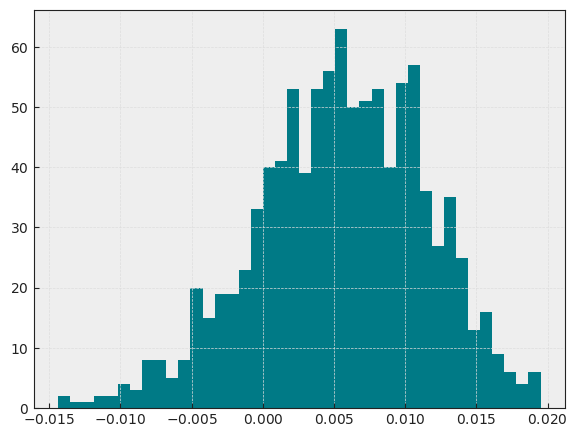

In [7]:
data = np.genfromtxt('../Examples/Data/flicker.dat', skip_header=25)
plt.hist(data, bins=40);

In [8]:
data.std(ddof=1) / np.sqrt(len(data))  # Typical Type A uncertainty evaluation

0.00018909621121798552

However, the data points in this array are correlated in time.
The `datasets.autocorrelation` method computes the autocorrelation versus lag array, which can be used to generate the autocorrelaion plot.

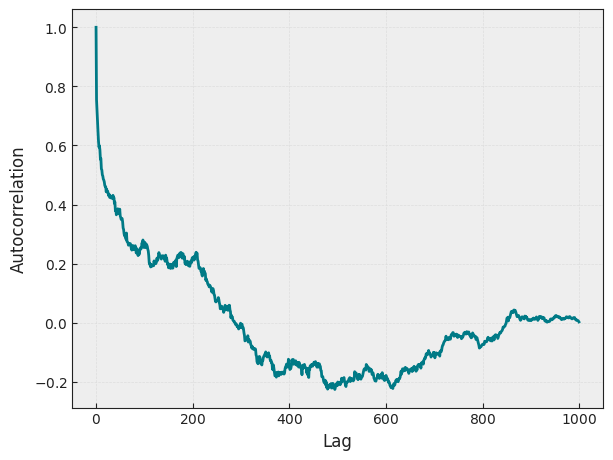

In [9]:
autocor = datasets.autocorrelation(data)
plt.plot(autocor)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

Accounting for this autocorrelation, the estimate of uncertainty may be computed using `datasets.uncert_autocorrelated`.
This results in a much larger estimate of uncertainty.
In the resulting tuple, the `uncert` parameter is the uncertainty estimate, while `r` is the multiplier used to expand the computed variance, and `r_unc` the multiplier to expand the computed uncertainty, to account for autocorrelation.
In this example, the uncertainty is 7.2 times higher than the typical Type A evaluation done above. `nc` is the cut-off lag, the lag at which autocorrelation becomes insignificant.

In [10]:
datasets.uncert_autocorrelated(data)

AutoCorrelationResult(rho=array([ 1.00000000e+00,  7.54390287e-01,  7.17001619e-01,  6.71882555e-01,
        6.47759414e-01,  6.15819107e-01,  5.94612346e-01,  5.98952131e-01,
        5.84441806e-01,  5.53246079e-01,  5.56283437e-01,  5.20484420e-01,
        5.16767272e-01,  5.00485055e-01,  4.96297654e-01,  4.86136023e-01,
        4.82882201e-01,  4.76915011e-01,  4.65305704e-01,  4.60532185e-01,
        4.59938375e-01,  4.43402884e-01,  4.51572612e-01,  4.41803096e-01,
        4.44570141e-01,  4.38687302e-01,  4.30129982e-01,  4.34942621e-01,
        4.24478117e-01,  4.30111045e-01,  4.28490837e-01,  4.22212367e-01,
        4.23531538e-01,  4.24830075e-01,  4.20600233e-01,  4.31144985e-01,
        4.19350742e-01,  4.23384794e-01,  4.03773490e-01,  4.08782244e-01,
        3.79123968e-01,  3.82487459e-01,  3.65237452e-01,  3.81648883e-01,
        3.76251874e-01,  3.85687177e-01,  3.79375214e-01,  3.83085618e-01,
        3.68847470e-01,  3.84459234e-01,  3.61586705e-01,  3.56333548e-01,

Refer to the paper by Nien Fan Zhang in Metrologia 43 (2006) for mathematical details of the calculation.